In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from importlib import reload
import wrapper
from wrapper.models.bubble import BubbleBurster
from trecs.components import Users
from src.utils import get_topic_clusters
from sklearn.decomposition import NMF
from wrapper.metrics.evaluation_metrics import SerendipityMetric, DiversityMetric, NoveltyMetric, TopicInteractionMeasurement
import os
import src
import trecs
from trecs.models import ContentFiltering
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement

random_state = np.random.seed(42)

In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [3]:
ratings_df = pd.read_csv('data/ml-100k/u.data', sep="\t", names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

## Creating RecommenderSystem on MovieLens 

### Creating Embeddings

In [4]:
from sklearn.decomposition import NMF

binary_ratings_df = ratings_df.drop(columns=['Timestamp'])
binary_ratings_df.loc[binary_ratings_df['Rating'] > 0, 'Rating'] = 1

# turn dataframe into matrix where each movie is a column and each user is a row
binary_ratings_matrix = binary_ratings_df.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0).to_numpy()

In [5]:
from lightfm.cross_validation import random_train_test_split
from scipy import sparse

# split data into train and test sets
train_interactions, test_interactions = random_train_test_split(sparse.csr_matrix(binary_ratings_matrix), test_percentage=0.2, random_state=random_state)
train_interactions = train_interactions.toarray()
test_interactions = test_interactions.toarray()

c:\Users\Jannik\anaconda3\envs\rsenv\lib\site-packages\lightfm\_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


In [6]:
n_attrs=100
max_iter=500

if not os.path.exists('artefacts/'):
    os.mkdir('artefacts/')

user_representation_file_path = f'artefacts/ml_user_representations_{max_iter}maxiter.npy'
item_representation_file_path = f'artefacts/ml_item_representations_{max_iter}maxiter.npy'
if not os.path.exists(user_representation_file_path) or not os.path.exists(item_representation_file_path):
    nmf = NMF(n_components=n_attrs, init='random', random_state=random_state, max_iter=max_iter)
    user_representation = nmf.fit_transform(train_interactions)
    item_representation = nmf.components_
    np.save(user_representation_file_path, user_representation)
    np.save(item_representation_file_path, item_representation)
else:
    user_representation = np.load(user_representation_file_path)
    item_representation = np.load(item_representation_file_path)

print(user_representation.shape, item_representation.shape)

(943, 100) (100, 1682)


In [7]:
users = Users(actual_user_profiles=user_representation, repeat_interactions=False, attention_exp=1.5)

## Create Fair RS Model

In [8]:
reload(wrapper.metrics.evaluation_metrics)
reload(wrapper.models.bubble)
from wrapper.models.bubble import BubbleBurster
from wrapper.metrics.evaluation_metrics import SerendipityMetric, DiversityMetric, NoveltyMetric

In [9]:
# Define topic clusters using NMF
max_iter=200
nmf_solver='mu'

topic_clusters_file_path = f'artefacts/ml_topic_clusters_{max_iter}maxiter_{nmf_solver}solver.npy'
if not os.path.exists(topic_clusters_file_path):
    item_topics = get_topic_clusters(binary_ratings_matrix, n_attrs=n_attrs, max_iter=max_iter, nmf_solver=nmf_solver)
    np.save(topic_clusters_file_path, item_topics)
else:
    item_topics = np.load(topic_clusters_file_path)

In [10]:
# Baseline Model
recsys = BubbleBurster(
    item_topics=item_topics,
    actual_item_representation=item_representation,
    actual_user_representation=users,
    record_base_state=True,
)

In [11]:
# Add metrics
user_pairs = [(u_idx, v_idx) for u_idx in range(recsys.num_users) for v_idx in range(recsys.num_users)]

recsys.add_metrics(InteractionMeasurement(), MSEMeasurement(diagnostics=True), InteractionSpread(), InteractionSimilarity(pairs=user_pairs), RecSimilarity(pairs=user_pairs),
                #    SerendipityMetric(), DiversityMetric(), NoveltyMetric()
                )

In [ ]:
print("Model representation of users and items are given by:")
print(f"- An all-zeros matrix of users of dimension {recsys.predicted_user_profiles.shape}")
print(f"- A randomly generated matrix of items of dimension {recsys.predicted_item_attributes.shape}")

## Simulation

### Baseline (myopic)

In [ ]:
# Baseline (myopic)
timesteps=20
# recsys.startup_and_train(timesteps=timesteps)

In [ ]:
myopic_measurements = recsys.get_measurements()
myopic_measurements_df = pd.DataFrame(myopic_measurements)


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3))

myopic_measurements_df['rec_similarity'].plot(ax=ax[0])
myopic_measurements_df['interaction_similarity'].plot(ax=ax[1])

ax[0].set_title('Recommendation similarity')
ax[0].set_xlabel('Timestep')
ax[0].set_ylabel('Similarity')
ax[1].set_title('Interaction Similarity')
ax[1].set_xlabel('Timestep')
ax[1].set_ylabel('Jaccard Similarity')

### Fair Model

In [12]:
import trecs.matrix_ops as mo
import scipy.spatial as sp
from numpy.linalg import norm

def cosine_similarity_reranking(predicted_user_profiles, predicted_item_attributes):
    # Reranking
    alpha = 0.1
    predicted_scores = mo.inner_product(predicted_user_profiles, predicted_item_attributes)
    # create a vector that contains the norms of all row vectors in predicted_user_profiles
    user_norms = norm(predicted_user_profiles, axis=1)
    item_norms = norm(predicted_item_attributes, axis=0)

    # create a matrix that contains the outer product of user_norms and item_norms
    norms = np.outer(user_norms, item_norms)
    # print max value of norms
    re_ranked_scores = predicted_scores + alpha * norms
    return re_ranked_scores

In [18]:
# Fair Model
recsys = BubbleBurster(
    item_topics=item_topics,
    user_representation=user_representation,
    item_representation=item_representation,
    actual_item_representation=item_representation,
    actual_user_representation=users,
    record_base_state=True,
    score_fn=cosine_similarity_reranking,
)

In [19]:
recsys.add_metrics(InteractionMeasurement(), MSEMeasurement(diagnostics=True), InteractionSpread(), InteractionSimilarity(pairs=user_pairs), RecSimilarity(pairs=user_pairs),# TopicInteractionMeasurement(),
                #    SerendipityMetric(), DiversityMetric(), NoveltyMetric()
                )

In [20]:
sum(recsys.user_topic_history)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [21]:
# Fair Model
timesteps=10
recsys.startup_and_train(timesteps=timesteps)

100%|██████████| 10/10 [03:02<00:00, 18.25s/it]


In [22]:
fair_measurements = recsys.get_measurements()

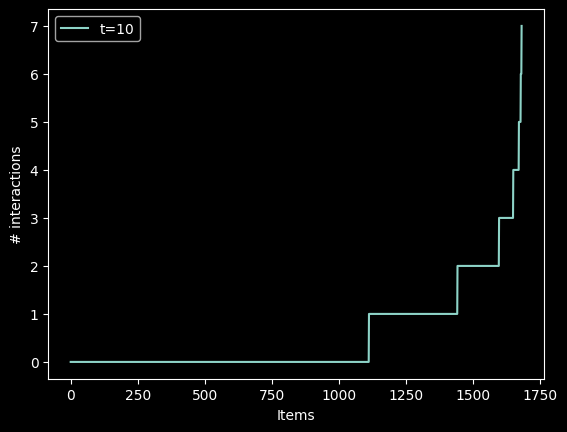

In [23]:
# for every 10 timesteps plot line in different color
for i in range(10, timesteps+10, 10):
    plt.plot(np.arange(recsys.num_items), sorted(fair_measurements['interaction_histogram'][i]), label=f't={i}')

plt.legend()
plt.xlabel("Items")
plt.ylabel("# interactions")
plt.show()

In [26]:
fair_measurements_df = pd.DataFrame(fair_measurements)
# for each key in fair_measurements print length of values
display(fair_measurements_df.head(2))

,interaction_histogram,mse,interaction_spread,interaction_similarity,rec_similarity,timesteps
0,None,0.101459,NaN,NaN,NaN,0
1,"[1.0, 0.0, 2.0, 3.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...",0.101459,-940.0,0.002266,0.004177,1


Text(0, 0.5, 'Jaccard Similarity')

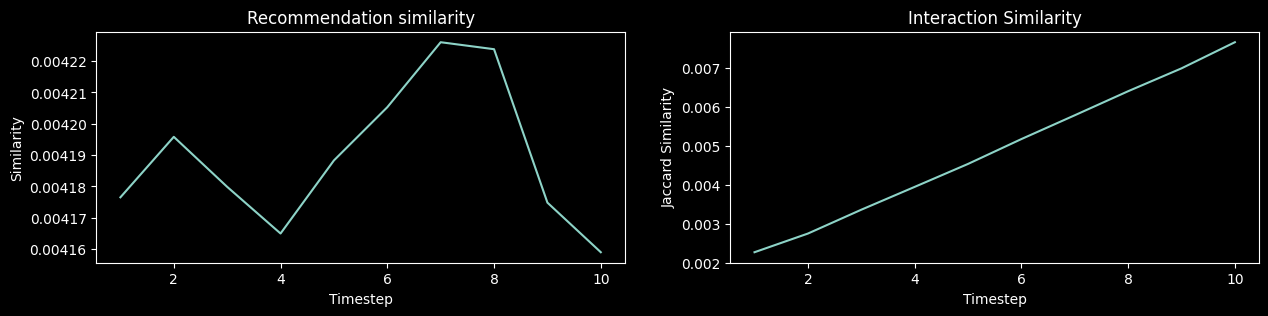

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3))

fair_measurements_df['rec_similarity'].plot(ax=ax[0])
fair_measurements_df['interaction_similarity'].plot(ax=ax[1])

ax[0].set_title('Recommendation similarity')
ax[0].set_xlabel('Timestep')
ax[0].set_ylabel('Similarity')
ax[1].set_title('Interaction Similarity')
ax[1].set_xlabel('Timestep')
ax[1].set_ylabel('Jaccard Similarity')

In [ ]:
# print majority / minority outcome stats
def majority_minority_outcomes(metric, split_index):
    split_indices = [split_index]

        
    maj_mean = metric.last_observation[:split_index].mean()
    maj_std = metric.last_observation[:split_index].std()

    min_mean = metric.last_observation[split_index:].mean()
    min_std = metric.last_observation[split_index:].std()

    print("Majority group statistics: ", maj_mean, "(mean), ", maj_std, "(std)")
    print("Minority group statistics: ", min_mean, "(mean), ", min_std, "(std)")
    print()
    
    metric.hist(split_indices)

In [ ]:
majority_minority_outcomes(mse, )